   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,306 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-secu

Text(0, 0.5, 'packets_per_sec')

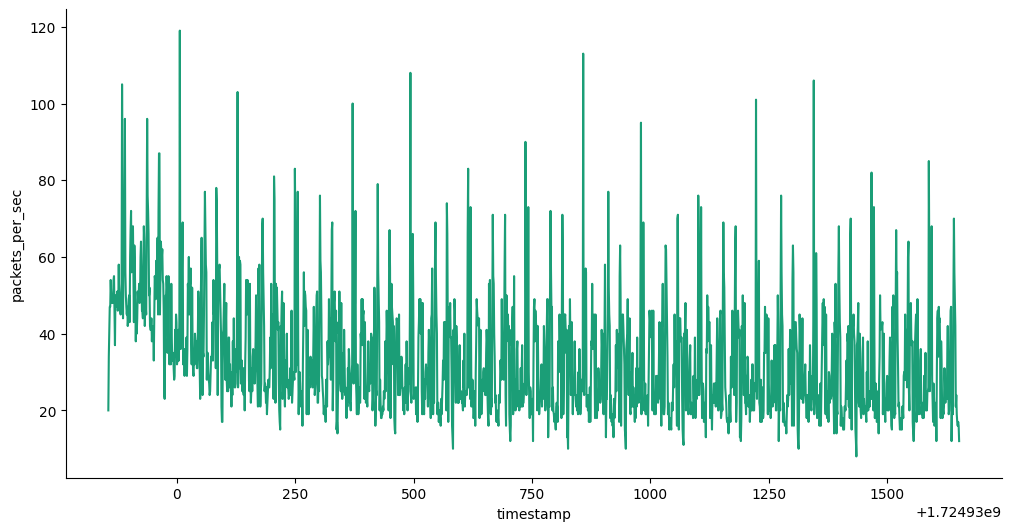

In [1]:
'''
Environment setup: Installing required dependencies

1. Install Python libraries:
   - pyshark: A Python wrapper for TShark, enabling packet capture and analysis.
   - pandas: A data manipulation library for organizing and analyzing packet data in tabular format.

2. Install nest_asyncio:
   - Enables nested asyncio event loops, required for pyshark to function in environments like Jupyter.

3. Update system package list:
   - Ensures the system has the latest information about available software packages.

4. Install TShark:
   - A command-line network protocol analyzer used by pyshark to process PCAP files.
'''

!pip install pyshark pandas
!pip install nest_asyncio
!apt-get update
!apt-get install -y tshark

import pyshark
import pandas as pd
import nest_asyncio
from matplotlib import pyplot as plt
import seaborn as sns

# Mounting to Google Drive for accessing and saving data
from google.colab import drive
drive.mount('/content/drive')

# Enabling nested asyncio
nest_asyncio.apply()

# Defining the path to the PCAP file
pcap_file_path = '/content/drive/My Drive/pcap/server.pcap'

# Lists to store timestamps and packet sizes
timestamps = []
packet_sizes = []

# Capturing packets and extracting data
cap = pyshark.FileCapture(pcap_file_path)
for packet in cap:
    timestamps.append(int(packet.sniff_time.timestamp()))

    # Attempt to extract length from various layers
    try:
        packet_sizes.append(int(packet.eth.len))  # Ethernet layer
    except AttributeError:
        try:
            packet_sizes.append(int(packet.ip.len))  # IP layer
        except AttributeError:
            packet_sizes.append(None)  # Handle other cases

cap.close()

# Creating a DataFrame with timestamps and packet sizes
df = pd.DataFrame({'timestamp': timestamps, 'packet_size': packet_sizes})

# Grouping by timestamp and calculating packets per second and average packet size
grouped_data = df.groupby('timestamp').agg({'packet_size': ['count', 'mean']})
grouped_data.columns = ['packets_per_sec', 'avg_packet_size']

# Saving the results to a CSV file
csv_file_path = '/content/drive/My Drive/pcap/packets_per_sec_analysis.csv'
grouped_data.to_csv(csv_file_path, index=False)

# Plotting the results
def plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series.index
    ys = series['packets_per_sec']

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = grouped_data.sort_values('timestamp', ascending=True)
plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
plt.ylabel('packets_per_sec')